# Sleep Stage Scoring (on raw EEG signal)

Inspired by:
1. [Personalizing deep learning models for automatic sleep staging, 2018](https://arxiv.org/abs/1801.02645)
2. [DeepSleepNet: a Model for Automatic Sleep Stage Scoring based on Raw Single-Channel EEG, 2017](https://arxiv.org/abs/1703.04046)
3. [Automatic Sleep Stage Scoring with Single-Channel EEG Using Convolutional Neural Networks, 2016](https://arxiv.org/abs/1610.01683)


### DATA

The project is based on the data from [the sleep-EDF database from Physionet](https://www.physionet.org/pn4/sleep-edfx/). The dataset consists of 39 EEG recordings of 20 patients (*SC* prefix). These raw recordings were preprocessed with the script **prepare_physionet.py** which is available in [deepsleepnet repo](https://github.com/akaraspt/deepsleepnet). 

#### Preprocessing pipeline:

1. Extract **fpz-cz** and **pz_oz** channels
2. Remove *MOVEMENT* and *UNKNOWN* stages in order to retain only sleep time
3. Merge  *N3* and *N4* stages into a single stage *N3* in order to comply with the AASM standard used in DeepSleepNet model
4. Split the remaining signal into 30s EEG epochs (each epoch has a stage label)
5. Save the file into *npz* file

Sample *npz* files can be found in [the data directory](data).


### OBJECTIVE: 
##### Classification of 30s EEG epochs into 5 sleep stages (W, N1, N2, N3, REM) using single-channel input (Fpz-Cz or Pz-Oz electrode)

### MODEL AND SOME REMARKS: 

The base model, depicted below, is a simplified version of the model used in [[2, 2017]](https://arxiv.org/abs/1703.04046). In the original paper the model consisted of two parts: representational learning (CNN) and residual learning (LSTM). A lof of complexity resides in the CNN layers, so due to limited computational resources I decided to concentrate solely on the first part.

The motivation behind this architecture, which comprises two CNNs with small and large filter sizes, comes from signal processing. Two CNNs with different filter sizes allow to extract features which represent both temporal information and frequency information. 

As an input I used single channel 30s EEG epochs. However, I also explored the approach used in [[3, 2016]](https://arxiv.org/abs/1610.01683). In order to preserve transitional information (probability of a stage to come after another), the target epoch was augmented with 1-3 previous epochs. 

One significant remark concerns the model validation. In [[2, 2017]](https://arxiv.org/abs/1703.04046) was stated that it is important to  have independent train and test sets: the data used for testing should not belong to a patient whose data was used in training. In this project all models were validated with this principle in mind. However, I used partial cross-validation (not using all folds) due to aforementioned limited computational resources.

<img src="img/arch.png" width="600" height="800">

### METRICS: 

Following the lead of the three articles presented above, I am using F1 score per class, and mean F1 score as a primary metric.

In [77]:
import random
import numpy as np
import pandas as pd
import os
import re

from collections import OrderedDict

from npzloader import DataLoader

import seaborn as sns
sns.set(style='darkgrid')

from tabulate import tabulate
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score

from keras.callbacks import Callback
from keras.layers import Dense, GRU, Input, LSTM, Bidirectional, Dropout, Activation, Conv1D, Conv2D, concatenate
from keras.layers import GlobalMaxPool1D, GlobalAveragePooling1D, MaxPooling1D, AveragePooling1D, Flatten, Add, Reshape 
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import backend as K
from keras import metrics

import warnings
warnings.filterwarnings("ignore")

In [3]:
# loading fpz_cz and pz_oz channels
loader = DataLoader("data/fpz_cz")
data_fp, labels = loader.load_data(verbose=0)

loader = DataLoader("data/pz_oz")
data_pz, _ = loader.load_data(verbose=0)

all_labels = np.hstack(labels.values())
enc = LabelBinarizer()
enc.fit(all_labels);

In [4]:
# int-to-label map
class_dict = {0: "W", 
              1: "N1",
              2: "N2",
              3: "N3",
              4: "REM"}

### EXPLORATION

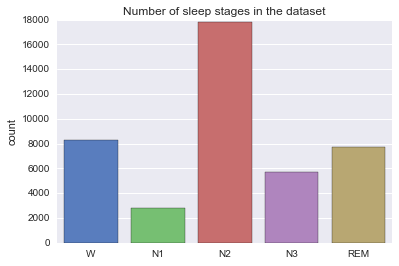

In [5]:
all_labels = [class_dict[i]  for i in all_labels]
sns.countplot(all_labels, palette='muted').set_title('Number of sleep stages in the dataset');

In [173]:
#labels['data/fpz_cz/SC4001E0.npz'][0] - 0
#labels['data/fpz_cz/SC4001E0.npz'][60] - 1
#labels['data/fpz_cz/SC4001E0.npz'][600] - 2
#labels['data/fpz_cz/SC4001E0.npz'][100] - 3
#labels['data/fpz_cz/SC4001E0.npz'][700] - 4

# function to plot EEG signal
def plot_channels(subject, n_stage, timesteps=1000):
    
    fpz_name = 'fpz_cz/{}'.format(subject)
    stage_name = labels[subject][n_stage]
    stage_name = class_dict[stage_name]
    pz_name = 'pz_oz/{}'.format(subject)
    
    fpz_example = np.squeeze(data_fp[fpz_name][n_stage][:timesteps])
    pz_example = np.squeeze(data_pz[pz_name][n_stage][:timesteps])
    signal = np.concatenate([fpz_example, pz_example])
    channel = ['fpz_cz'] * timesteps + ['pz_oz'] * timesteps
    time = list(range(timesteps)) * 2
    subject = [subject] * timesteps * 2
    
    df = pd.DataFrame({'signal':signal, 
                       'channel':channel, 
                       'time':time, 
                       'subject':subject}, index=range(timesteps*2))
    
    title = 'EEG signal for {} stage: {}s'.format(stage_name, timesteps / 100)
    sns.tsplot(time='time', 
               value='signal', 
               condition='channel', 
               unit='subject', data=df).set_title(title);  

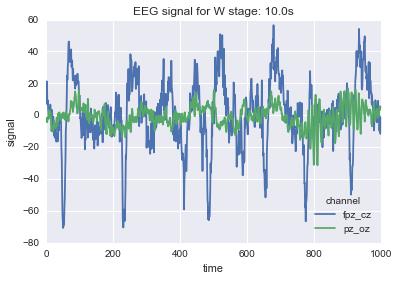

In [7]:
plot_channels(subject='SC4001E0', n_stage=0)

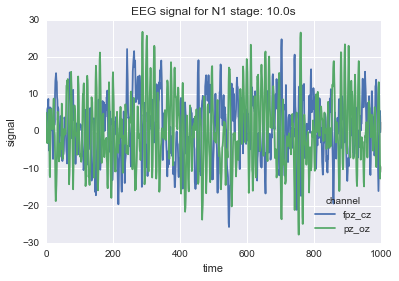

In [8]:
plot_channels(subject='SC4001E0', n_stage=60)

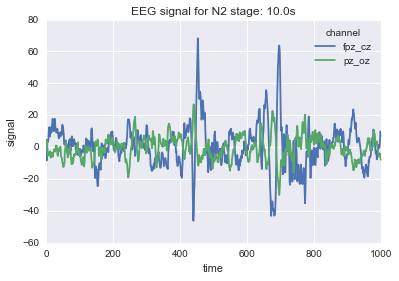

In [9]:
plot_channels(subject='SC4001E0', n_stage=600)

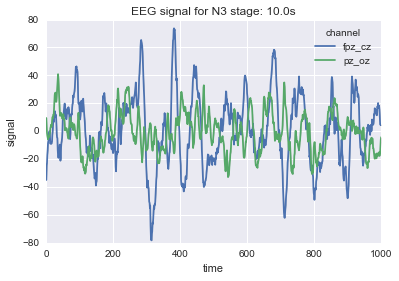

In [10]:
plot_channels(subject='SC4001E0', n_stage=100)

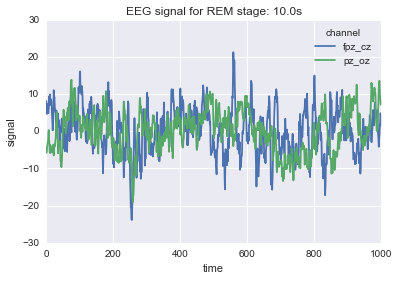

In [11]:
plot_channels(subject='SC4001E0', n_stage=700)

### TRAINING

In [5]:
"""
Function to visualize the learning dynamics.
"""

metrics_to_plot = [('categorical_accuracy','val_categorical_accuracy'), 
           ('mean_squared_error','val_mean_squared_error'),
           ('loss', 'val_loss')]

def plot_learning(histories, metrics=metrics_to_plot, message=''):
    n = len(histories)
    for training, test in metrics:
        
        train_values = [history.history[training] for history in histories]      
        train_values = [sum(x) for x in zip(*train_values)]
        train_values = [x/n for x in train_values]
               
        test_values = [history.history[test] for history in histories]
        test_values = [sum(x) for x in zip(*test_values)]
        test_values = [x/n for x in test_values]
                
        plt.plot(train_values)
        plt.plot(test_values)
        plt.title(message+'\n'+training)
        plt.ylabel(training)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

In [44]:
"""
Function to randomly select subjects for partial cross-validation and prepare the data for training.
Train and test sets should be independent.
A patient with is SC413 is excluded from any test set because this patient has only one recording.
"""

def get_cv_data(data, labels, n_folds=3, ch=None):
    
    random.seed(29)
    
    keys = list(labels.keys())
    keys = list(set([x[:5] for x in keys if '413' not in x]))
    random.shuffle(keys)
    val_keys = keys[:n_folds]
    cv_data = []
    
    for fold in val_keys:
        fold_keys = [fold+'1E0', fold+'2E0']
        val_labels = [labels[key] for key in fold_keys]
        val_labels = np.hstack(val_labels)
        val_labels = enc.transform(val_labels)
               
        train_labels = [labels[key] for key in labels.keys() if key not in fold_keys]
        train_labels = np.hstack(train_labels)
        train_labels = enc.transform(train_labels)
        
        if ch:
            val_data = [data['{}/{}'.format(ch,key)] for key in fold_keys]
            train_data = [data['{}/{}'.format(ch,key)] for key in labels.keys() if key not in fold_keys]          
        else:
            val_data = [data[key] for key in fold_keys]
            train_data = [data[key] for key in labels.keys() if key not in fold_keys]
                        
        train_data = np.vstack(train_data)
        val_data = np.vstack(val_data)
        
        cv_data.append((train_data, train_labels, val_data, val_labels))
    
    return cv_data 

"""
Function to slide on array with a moving window of size n
"""

def _slide(data, labels, n=3):
    
    #zero-indexing
    data = [data[i:i+n] for i, _ in enumerate(data[n:])]
    data = [np.vstack(x) for x in data]
    data = np.array(data)
    
    labels = labels[n:]
    
    assert data.shape[0] == labels.shape[0]
    
    return data, labels

"""
Function to do batch processing with _slide()
"""

def batch_slide(data_dict, labels_dict, n=3):
    
    keys = [(x,y) for x,y in zip(data_dict, labels_dict)]
    data = [_slide(data_dict[x], labels_dict[y], n=n) for x,y in keys]
    
    data_keys, label_keys = zip(*keys)
    data, labels = zip(*data)
    
    data_dict = {k:v for k,v in zip(data_keys, data)}
    data_dict = OrderedDict(sorted(data_dict.items()))
    
    labels_dict = {k:v for k,v in zip(label_keys, labels)}
    labels_dict = OrderedDict(sorted(labels_dict.items()))
        
    return data_dict, labels_dict
    
"""
Function to merge channels into single recording.
axis = 0: merge channels along the first dimension - (3000,1) and (3000,1) --> (6000,1)
axis = 0: merge channels along the second dimension - (3000,1) and (3000,1) --> (3000,2)
"""

def merge_channels(channels, axis=0):
    
    # number of records should be the same in all channels
    assert len(set([len(r) for r in channels])) == 1
    
    keys = [ch.keys() for ch in channels]
    
    merged = {}
    
    for records in zip(*keys):
        
        # assert that all recordings are for the same patient
        assert len(set([r.split('/')[1] for r in records])) == 1
        vals = [ch[r] for r, ch in zip(records, channels)]
        if axis:
            stacked = np.dstack(vals)
        else:
            stacked = np.hstack(vals)
        patient = records[0].split('/')[1]
        merged[patient] = stacked
        
    merged = OrderedDict(sorted(merged.items()))
    return merged


"""
Function to merge channels into single recording.
axis = 0: merge channels along the first dimension - (3000,1) and (3000,1) --> (6000,1)
axis = 0: merge channels along the second dimension - (3000,1) and (3000,1) --> (3000,2)
"""

def train_and_report(cv_data, timesteps=3000, n_cnn_dense=128, epochs=5, input_dim=1, verbose=0):
    histories = []
    f1_scores = []
    for i, (train_data, train_labels, val_data, val_labels) in enumerate(cv_data):
        print('FOLD {}'.format(i))
        validation_data = (val_data, val_labels)
        model = create_model(n_cnn_dense=n_cnn_dense, timesteps=timesteps, input_dim=input_dim)
        history = model.fit(train_data, train_labels, batch_size=64, epochs=epochs, 
                            validation_data=validation_data, shuffle=True, verbose=verbose)
        histories.append(history)
        
        y_pred = model.predict(val_data)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(val_labels, axis=1)
        
        f1 = f1_score(y_true, y_pred, average=None)
        f1_scores.append(f1)
    
    f1_scores = np.sum(f1_scores, axis=0) / len(f1_scores)   
    return histories, f1_scores

"""
Function to create a model described in the introduction section.
"""

def create_model(n_cnn_dense=128, drop=True, input_dim=1, timesteps=3000, fs=100, num_classes=5):
    
    input_dim = input_dim
    timesteps = timesteps   
    inp = Input(shape=(timesteps, input_dim))
    fs = fs
    num_classes = num_classes
    
    x = Conv1D(filters=64, kernel_size=fs//2, strides=fs//16, activation='relu', padding='same')(inp)
    x = MaxPooling1D(pool_size=8, strides=8, padding='same')(x)
    if drop:
        x = Dropout(0.5)(x)
    x = Conv1D(filters=128, kernel_size=8, activation='relu', padding='same')(x)
    x = Conv1D(filters=128, kernel_size=8, activation='relu', padding='same')(x)
    x = Conv1D(filters=128, kernel_size=8, activation='relu', padding='same')(x)
        
    y = Conv1D(filters=64, kernel_size=fs*4, strides=fs//2,  activation='relu', padding='same')(inp)
    y = MaxPooling1D(pool_size=4, strides=4, padding='same')(y)
    if drop:
        x = Dropout(0.5)(x)
    y = Conv1D(filters=128, kernel_size=6, activation='relu', padding='same')(y)
    y = Conv1D(filters=128, kernel_size=6, activation='relu', padding='same')(y)
    y = Conv1D(filters=128, kernel_size=6, activation='relu', padding='same')(y)
    
    xy = concatenate([x, y], axis=1)
    
    output = Dense(n_cnn_dense, activation='relu')(xy)
    pool_size = int(output.shape[1]) // 4
    output = MaxPooling1D(pool_size=pool_size, strides=pool_size, padding='valid')(output)
    output = Flatten()(output)
        
    output = Dense(num_classes, activation='softmax')(output)
    
    model = Model(inputs=inp, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.categorical_accuracy, metrics.mean_squared_error])
    return model   

#### *FPZ-CZ* channel 

In [45]:
ch = 'fpz_cz'

In [7]:
# getting cross-valivation data
# note: n_folds is not a number of folds in traditional sense
# the model is trained on 19 patients and validated on 1,
# so n_folds is a number of patients for validation
# to perform full cross-validation n_folds should be equal to 19 
# (not 20, because for SC413 patient there is only one record)
cv_data = get_cv_data(data_fp, labels, ch=ch, n_folds=4)
histories_1, f1_scores_1 = train_and_report(cv_data, epochs=10, timesteps=3000, verbose=0)

FOLD 0
FOLD 1
FOLD 2
FOLD 3


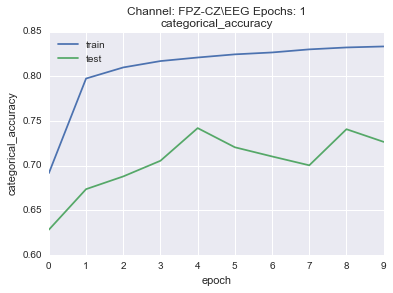

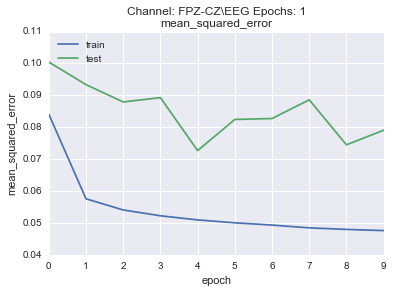

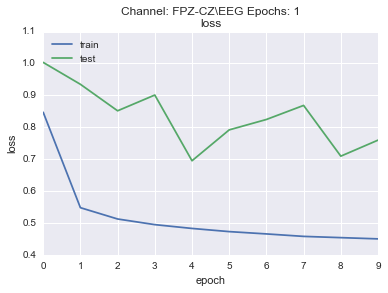

In [49]:
plot_learning(histories_1, message = 'Channel: FPZ-CZ\EEG Epochs: 1')

In [8]:
# adding historical data (1 additional EEG epoch) - 6000 timesteps
data_fp_slided, labels_slided =  batch_slide(data_fp, labels, n=2)
cv_data = get_cv_data(data_fp_slided, labels_slided, ch=ch, n_folds=4)
histories_2, f1_scores_2 = train_and_report(cv_data, epochs=10, timesteps=6000, verbose=0)

FOLD 0
FOLD 1
FOLD 2
FOLD 3


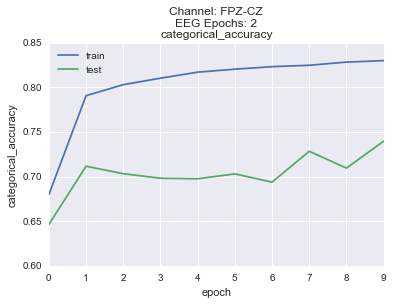

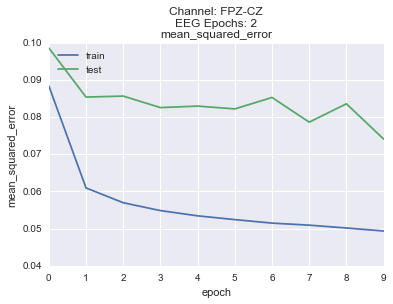

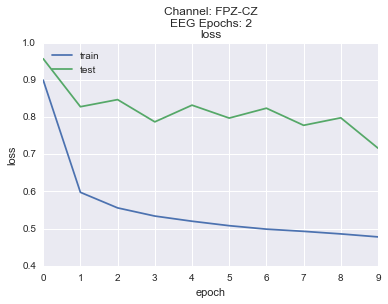

In [50]:
plot_learning(histories_2, message = 'Channel: FPZ-CZ\nEEG Epochs: 2')

In [9]:
# adding historical data (2 additional EEG epochs) - 9000 timesteps
data_fp_slided, labels_slided =  batch_slide(data_fp, labels, n=3)
cv_data = get_cv_data(data_fp_slided, labels_slided, ch=ch, n_folds=4)
histories_3, f1_scores_3 = train_and_report(cv_data, epochs=10, timesteps=9000, verbose=0)

FOLD 0
FOLD 1
FOLD 2
FOLD 3


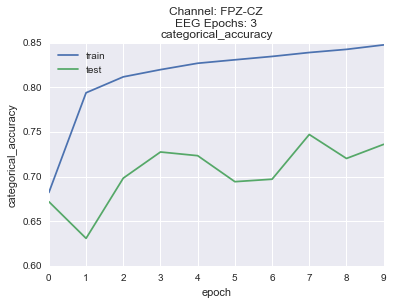

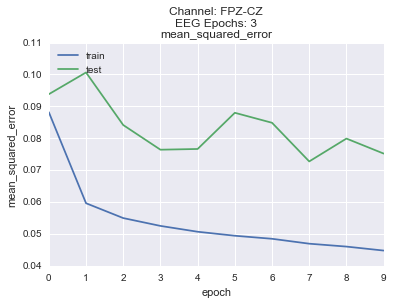

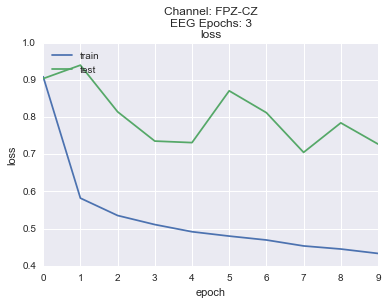

In [52]:
plot_learning(histories_3, message = 'Channel: FPZ-CZ\nEEG Epochs: 3')

#### *PZ-OZ* channel 

In [51]:
ch = 'pz_oz'

In [10]:
cv_data = get_cv_data(data_pz, labels, ch=ch, n_folds=4)
histories_4, f1_scores_4 = train_and_report(cv_data, epochs=10, timesteps=3000, verbose=0)

FOLD 0
FOLD 1
FOLD 2
FOLD 3


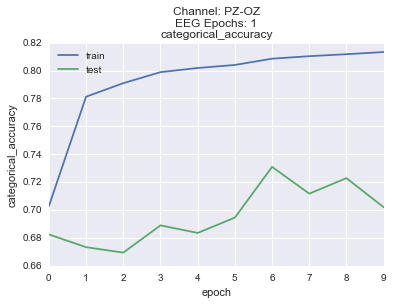

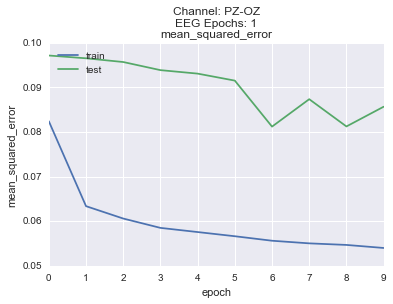

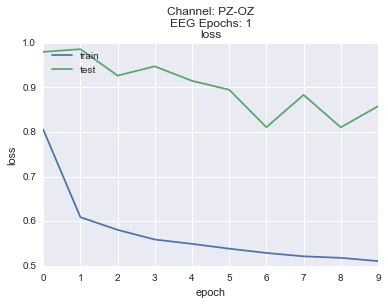

In [53]:
plot_learning(histories_4, message = 'Channel: PZ-OZ\nEEG Epochs: 1')

In [11]:
# adding historical data (1 additional EEG epochs) - 6000 timesteps
data_pz_slided, labels_slided =  batch_slide(data_pz, labels, n=2)
cv_data = get_cv_data(data_pz_slided, labels_slided, ch=ch, n_folds=4)
histories_5, f1_scores_5 = train_and_report(cv_data, epochs=10, timesteps=6000, verbose=0)

FOLD 0
FOLD 1
FOLD 2
FOLD 3


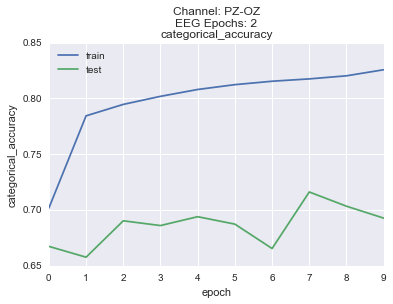

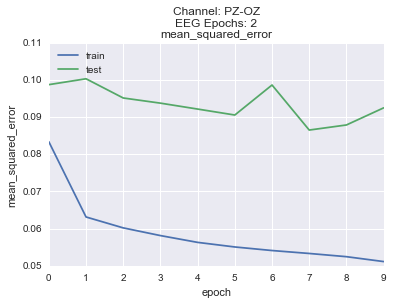

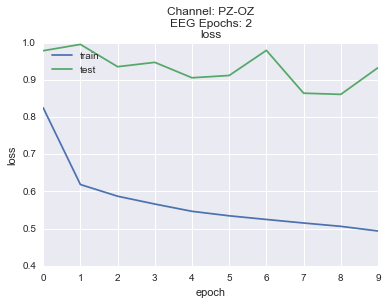

In [54]:
plot_learning(histories_5, message = 'Channel: PZ-OZ\nEEG Epochs: 2')

In [35]:
# adding historical data (2 additional EEG epochs) - 9000 timesteps
data_pz_slided, labels_slided =  batch_slide(data_pz, labels, n=3)
cv_data = get_cv_data(data_pz_slided, labels_slided, ch=ch, n_folds=4)
histories_6, f1_scores_6 = train_and_report(cv_data, epochs=10, timesteps=9000, verbose=0)

FOLD 0
FOLD 1
FOLD 2
FOLD 3


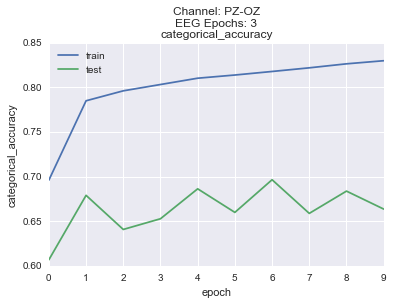

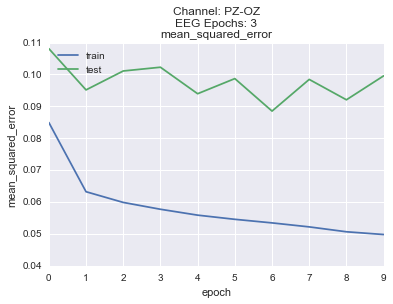

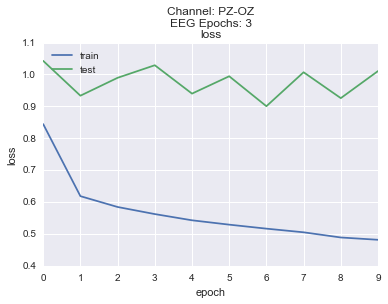

In [55]:
plot_learning(histories_6, message = 'Channel: PZ-OZ\nEEG Epochs: 3')

In [101]:
headers=['Experiment', 'W', 'N1', 'N2', 'N3', 'REM', 'Average F1']
experiments = ['fpz_cz_1','fpz_cz_2','fpz_cz_3','pz_oz_1','pz_oz_2','pz_oz_3']
f1_list = [f1_scores_1, f1_scores_2, f1_scores_3, f1_scores_4, f1_scores_5, f1_scores_6]
f1_list = [[ex] + list(f1) + [np.mean(f1)] for ex, f1 in list(zip(experiments, f1_list))]

In [102]:
print(tabulate(f1_list, headers=headers, tablefmt='pipe', stralign='center'))

|  Experiment  |        W |        N1 |       N2 |       N3 |      REM |   Average F1 |
|:------------:|---------:|----------:|---------:|---------:|---------:|-------------:|
|   fpz_cz_1   | 0.727257 | 0.161911  | 0.789659 | 0.751138 | 0.705836 |     0.62716  |
|   fpz_cz_2   | 0.751985 | 0.23196   | 0.791158 | 0.808178 | 0.708846 |     0.658425 |
|   fpz_cz_3   | 0.756488 | 0.207712  | 0.778186 | 0.783214 | 0.716464 |     0.648413 |
|   pz_oz_1    | 0.666432 | 0.0723625 | 0.808945 | 0.786825 | 0.649246 |     0.596762 |
|   pz_oz_2    | 0.652807 | 0.213322  | 0.773523 | 0.728693 | 0.674006 |     0.60847  |
|   pz_oz_3    | 0.656882 | 0.144928  | 0.733392 | 0.757925 | 0.62261  |     0.583147 |


### FURTHER WORK

1. Optimize the number of training epochs
2. Tackle unbalanced dataset, N1 stages show drastically different results comparing to other stages and it drags down average F1 score. Try oversampling and undersampling
3. Increase model complexity
4. Add LSTM/GRU layers
5. Try multichannel input
6. Try additional CRF layer like in [[2016]](https://arxiv.org/abs/1603.01360)
